# Local hard edge passing protocol

In [1]:
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np

import sys
sys.path.append('../')

sys.path.append('../../')

from panav.util import interpolate_positions

from panav.SIPP import SIPP

from matplotlib.animation import FuncAnimation

from IPython.display import HTML, display

from itertools import product
from panav.viz import animate_MAPF_R,draw_soft_hard

%load_ext autoreload
%autoreload 2

# N agent opposing environment with soft edges

In [67]:
N = 5

node_locs = np.array(np.meshgrid(np.arange(0,N),np.arange(0,N)))*2

S = len(node_locs)

G = nx.DiGraph()

for row,col in product(range(N),range(N)):
    nbs = [(row-1,col),(row+1,col),
           (row,col-1),(row,col+1)]
    
    for x,y in nbs:
        if 0<=x<N and 0<=y<N:
            G.add_edges_from([((row,col),(x,y)),((x,y),(row,col))])

nx.set_node_attributes(G,(0,0),'loc')

for row,col in product(range(N),range(N)):
    G.nodes[(row,col)]['loc'] = node_locs[:,row,col]

G = nx.convert_node_labels_to_integers(G)

node_locs = {s:G.nodes[s]['loc'] for s in G}

starts = np.arange(0,N*2,2)
goals = np.arange(N*(N-1),N**2)


for i,j in product(goals,goals):
    if (i,j) in G.edges:
        G.remove_edge(i,j)

for i,j in product(starts,starts):
    if (i,j) in G.edges:
        G.remove_edge(i,j)



G.remove_nodes_from([i for i in range(N*2,N*(N-2)) if i%N!=N//2])

for i,j in product(goals,goals):
    if (i,j) in G.edges:
        G.remove_edge(i,j)

for i,j in product(starts,starts):
    if (i,j) in G.edges:
        G.remove_edge(i,j)

G.remove_nodes_from([12])
hard_edges = [(17,5),(5,17)]

G.add_edges_from(hard_edges)

env = HybridGraphEnv(G,node_locs,hard_edges)

Green dashed edges: soft
Black solid edges: hard


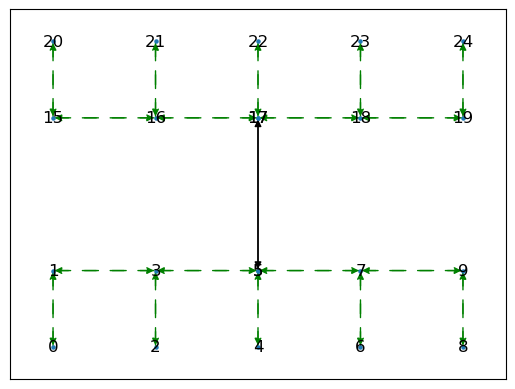

In [68]:
draw_soft_hard(env.G,node_locs,with_labels=True)
print('Green dashed edges: soft')
print('Black solid edges: hard')

In [69]:
true_starts = np.hstack([starts,goals])
true_goals = np.hstack([goals[::-1],starts[::-1]])

In [70]:

v_max = 1.0
bloating_r = 0.2

nx.set_edge_attributes(G,
                       {e:np.linalg.norm(node_locs[e[0]]-node_locs[e[1]])/v_max\
                          for e in G.edges},
                       'weight')

In [71]:
agents = np.arange(len(true_starts))
# Plan the agents' motions without avoiding conflicts
plan0 = []
for agent in agents:
    start,goal = true_starts[agent],true_goals[agent]
    plan = SIPP(G,node_locs,start,goal,[],v_max,bloating_r)
    plan0.append(plan)
joint_plan = plan0

In [77]:
# Simulate the execution of plans under passing protocol
exec_dt = 0.1
max_time_steps = 400
t = 0.0

agent_trajs = [[] for a in agents]


env = HybridGraphEnv(G,node_locs,hard_edges,bloating_r=bloating_r)
env.initialize_agent_states(agents,start_nodes=true_starts)

transition_id = [0 for a in agents]

times = [0 for a in agents]

for step in range(max_time_steps):
    for a in agents:
        _,loc = env.agent_states[a]
        agent_trajs[a].append(loc) # Record agents' locations.
    
    next_transitions = [(joint_plan[a][i][0],joint_plan[a][i+1][0]) for a,i in zip(agents,transition_id)]
    
    new_states = {} 
    for a in agents:
        new_states[a],transition_complete = env.step(a,next_transitions[a],exec_dt,v_max)
        
        # print('transition complete?',transition_complete)
        if transition_complete:
            transition_id[a] = np.min([transition_id[a]+1,len(joint_plan[a])-2])
            
                  
    all_reached = True
    for a in agents:
        node_edge,loc = new_states[a]
        env.agent_states[a] = new_states[a]
        # print('agent',a,'dist to goal',np.linalg.norm(loc-node_locs[true_goals[a]]))
        if np.linalg.norm(loc-node_locs[true_goals[a]])>0.5*bloating_r:
            all_reached = False
            times[a] = t

    
    # print('passing',env.G.edges[38,7]['passing'],env.G.edges[7,38]['passing'])
    # print('waiting',env.G.edges[38,7]['waiting'],env.G.edges[7,38]['waiting'])
    
    if all_reached:
        print('all reached')
        break
        
    t+=exec_dt

agent_trajs = [np.array(agent_trajs[a]).T for a in agents]

all reached


In [82]:
np.sum(times)

162.89999999999992

In [85]:

dt = exec_dt

anim = animate_MAPF_R(G,node_locs,[],agent_trajs,dt,bloating_r,true_starts,true_goals,interpolate=False)
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

# display(HTML(anim.to_jshtml()))
anim.save('Hard Edge Passing Simple.gif')
plt.close() 

In [73]:
from collections import deque
class HybridGraphEnv:
    def __init__(self,G,node_locs,hard_edges,
                 default_edge_capacity=3,default_node_capacity=3,bloating_r=0.0):
        '''
            G: a networkx directed graph.
        '''
        # Edge attributes
        nx.set_edge_attributes(G,'soft','edge_type')
        
        for e in hard_edges:
            G.edges[e]['edge_type']='hard'

        nx.set_edge_attributes(G,{e:deque() for e in G.edges},'waiting')
        
        nx.set_edge_attributes(G,{e:deque() for e in G.edges},'passing')
        
        nx.set_edge_attributes(G, default_edge_capacity,'capacity')
        
        # Node attributes
        nx.set_node_attributes(G,'soft','node_type') # By default, assume all nodes are soft.

        nx.set_node_attributes(G, default_node_capacity,'capacity')
        
        self.G = G
        self.node_locs = node_locs
        
        self.agent_states = {} # Agent states are (node,loc) tuple or (edge,loc) tuple
        
        self.bloating_r = bloating_r
        
        self.t = 0 # The clock of the environment.
        
    def update_clock(self,dt):
        self.t+=dt
        
    def get_curr_lock(self):
        return self.t
    
    def passable(self,edge):
        u,v = edge
        
        if self.G.edges[u,v]['edge_type']=='soft':
            return True
        
        if len(self.G.edges[v,u]['passing']) != 0:
            return False
        else:
            if len(self.G.edges[u,v]['passing']) == 0:
                return True
            else: # Avoid the closest agent in front.
                agent = self.G.edges[u,v]['passing'][-1]
                _,loc = self.agent_states[agent]
                if np.linalg.norm(loc-self.node_locs[u])<=2*self.bloating_r:
                    return False
                    
                return True
            
    def initialize_agent_states(self,agents,start_nodes):
        # Put the agents onto their initial nodes.
        for a,s in zip(agents,start_nodes): 
            self.agent_states[a] =(s, np.array(self.node_locs[s]))
    
    def step(self,agent_ID,action,dt,vmax=1.0):
        '''
            agent_ID: the agent's ID number.
            action: a (u,v) transition pair.
            dt: the time duration to execute the action.
            
            Output: the permissible state of the agent, (edge,loc) or (node,loc).
        '''
        u,v = action
        if u==v:
            s,agent_loc = self.agent_states[agent_ID]
            if s != u:
                print('Illegal action {} at agent {}. Agent state .'\
                      .format((u,v),agent_ID,self.agent_states[agent_ID]))
            else:
                return (s,agent_loc)
        else:
            e,agent_loc = self.agent_states[agent_ID]
            
            illegal_action = False
            
            if type(e) is tuple:
                illegal_action = (u,v) != e
            else:
                illegal_action = u!=e and v!=e
            # print('agent ID',agent_ID,'state e',e)
            if illegal_action:
                print('Illegal action {} at agent {}. Agent state .'\
                      .format((u,v),agent_ID,self.agent_states[agent_ID]))
            else:
                
                if type(e) is not tuple:# The agent is at u.
                    if agent_ID not in self.G.edges[u,v]['waiting']:
                        self.G.edges[u,v]['waiting'].append(agent_ID)
                    
                    # print('front?',agent_ID==self.G.edges[u,v]['waiting'][0],)
                    if agent_ID==self.G.edges[u,v]['waiting'][0] and\
                        self.passable((u,v)):
                        self.G.edges[u,v]['waiting'].remove(agent_ID)
                        self.G.edges[u,v]['passing'].append(agent_ID)
                        passable = True
                    else:
                        passable = False 
                else:
                    if self.G.edges[u,v]['edge_type']=='hard':
                        assert(agent_ID in self.G.edges[u,v]['passing'])
                        
                    passable = True
                        
                if passable:
                    u_loc,v_loc = self.node_locs[u],self.node_locs[v]

                    frac = np.linalg.norm(agent_loc - u_loc)/np.linalg.norm(v_loc - u_loc)

                    frac = np.min([1.0,frac + vmax*dt/np.linalg.norm(v_loc-u_loc)])
                    
                    agent_loc = frac * (v_loc - u_loc) + u_loc
                    if frac == 1.0:
                        self.G.edges[u,v]['passing'].remove(agent_ID)
                        # print('agent ID',agent_ID,'uv',u,v)
                        return (v,agent_loc),True 
                    else:
                        return ((u,v),agent_loc),False
                else:
                    # print('waiting')
                    return (u,agent_loc), False
        